In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.stats import gamma
import scipy.integrate
import pandas
# TO DO: Update to most recent Planck results
from astropy.cosmology import Planck18_arXiv_v2 as cosmo
import winsound

In [2]:
# Path to tables of cosmic variance values
path = "../../CV_Vals/"
file='constant'
save=1
# Get young, blue galaxy spectrum
data = np.loadtxt("../erb2010_continuum.dat")
x = data[:,0]
y = data[:,1] * x**2 / 3.e18 # Convert to correct flux values

# Constants
tot_sky = 41253. # Total degrees on the sky
masses = np.array([8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0]) # Mass bins in log(M/Msun)

# TO DO: Modify cosmic variance values from the tables such that masses <= 8 use the same cosmic variance values as 8.5
# Currently the CV values are incorrectly extrapolated to lower masses from a mass of 8.5
# The code used to calculated the CV values is called "getcv" and is included with the CV value files
#Done

trials = 10000 # Number of trials for calculating median from gamma function
mmin = 9 # Minimum halo mass for HMF
mmax = 13.5 # Maximum halo mass for HMF

In [3]:
# Function to find closest wavelength in measured galaxy spectrum compared to given value
def nearest_wavelength(x, val):
    i = (np.abs(x - val)).argmin()
    return x[i]

# Define a class for different survey designs
class survey:
    def __init__(self, ABmax, area, cv_file, wavelength = 0, num_pointings = 1):
        self.ABmax = ABmax # Limiting AB magnitude of the survey
        self.area = area # Survey area
        self.file = cv_file # Name of cosmic variance table file
        self.point = num_pointings # Number of independent pointings
        self.wavelength = wavelength # Center wavelength for the chosen filter

In [4]:
# Method to take one trial of a gamma distribution with a given variance and mean
def trial(sig_v, mean, trials=10000):
    var = sig_v**2*mean**2
    k = mean**2/var
    t = var/mean
    rand = np.rint(np.random.gamma(k, scale=t, size=trials))
    return rand

In [5]:
dfz = pandas.read_csv(path+"cv_mashian.csv")
z_vals=np.array(dfz["z"])
z_vals = z_vals[::-1]

[None,
 Text(0, 0.5, 'Number of trials'),
 Text(0.5, 0, '# galaxies'),
 Text(0.5, 1.0, 'z=15, M=1$0^{10} M_\\odot$')]

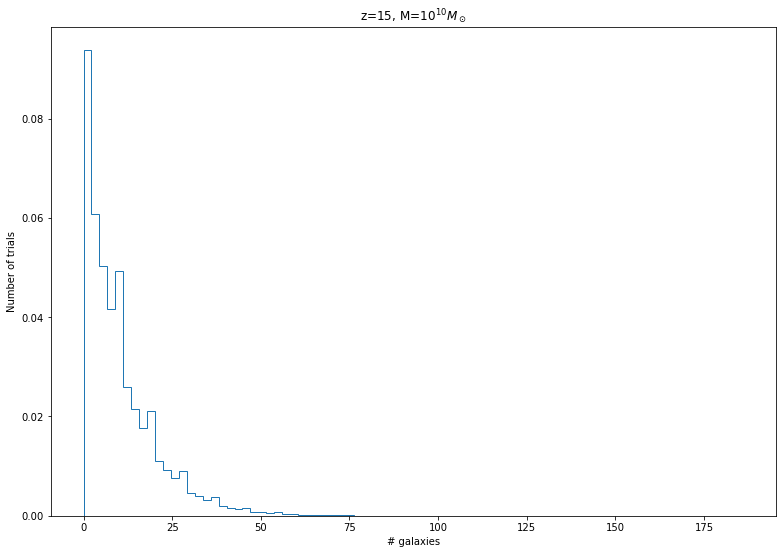

In [6]:
sig=float(dfz.loc[dfz['z'] == 15.311][[str(11.0)]].values[0][0])
fig, ax=plt.subplots(figsize=(13,9))
rand=trial(1, sig, trials=int(1e7))
vals, bins, _ = ax.hist(rand, bins=83, density=1, histtype='step');
ax.set(yscale='linear', title=r'z=15, M=1$0^{10} M_\odot$', xlabel='# galaxies', ylabel='Number of trials')

In [7]:
sum(vals*np.diff(bins))

0.9999999999999997

[None,
 Text(0, 0.5, 'Fraction of trials'),
 Text(0.5, 0, '# galaxies'),
 Text(0.5, 1.0, 'z=15, M=1$0^{11}$ $M_\\odot$')]

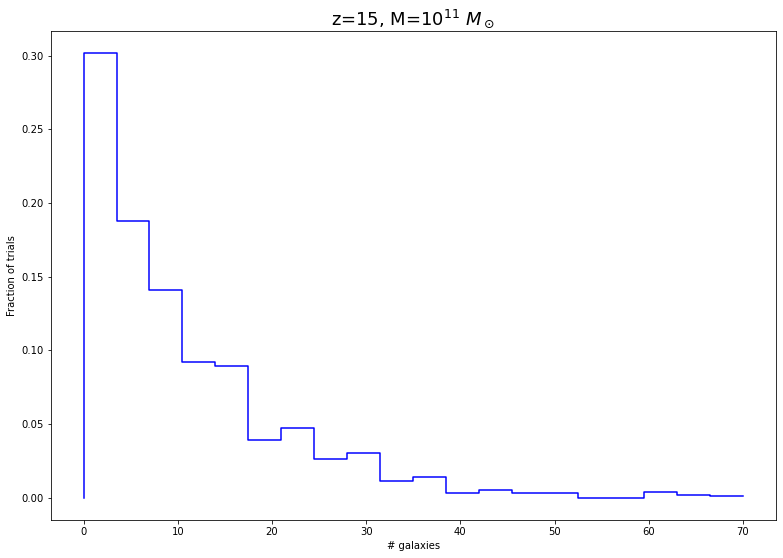

In [8]:
N=1e3
rand=trial(1, sig, trials=int(N))
hist, bin_edges = np.histogram(rand, bins=20)

# Get the reversed cumulative sum

# Get the cin centres rather than the edges
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.
fig, ax=plt.subplots(figsize=(13,9))
# Plot
extra=np.array([0])
plt.rcParams.update({'font.size': 15})
# plt.rc('font', family='serif')
plt.rc('text', usetex=False)

ax.step(bin_edges, np.hstack(([0],hist/N)), 'b')
ax.set(yscale='linear', title=r'z=15, M=1$0^{11}$ $M_\odot$', xlabel='# galaxies', ylabel='Fraction of trials')
# plt.savefig('highredshifthighmasstrial.pdf')

In [9]:
val=[-0.04418885, -0.95909967]
def lin(x,a=val[0],b=val[1]):
    return a*x+b

In [10]:
import funcs as func
from importlib import reload  
from tqdm import tqdm
reload(func);
mean_median=func.mean_median
lums=func.lums
mmrand=func.mmrand

In [11]:
# surveys={}
# deep = survey(30.7, 46./3600, "cv_jades_deep.csv", nearest_wavelength(x,14873.4))
# mean_deep, med_deep, sig = mmrand(deep)

In [12]:
surveys={}
deep = survey(30.7, 46./3600, "cv_jades_deep.csv", nearest_wavelength(x,14873.4))
meansdeep, sigdeep = mean_median(deep)
surveys['JADES Deep']=meansdeep, sigdeep

wide = survey(29.8, 190./3600, "cv_jades_wide.csv", nearest_wavelength(x,14873.4))
meanswide, sigwide = mean_median(wide)
surveys['JADES Medium']=meanswide, sigdeep

deepE = survey(30.7, 190./3600, "cv_jades_deep_extend.csv", nearest_wavelength(x,14873.4))
meansdeepE, sigdeepE = mean_median(deepE)
surveys['JADES Deep Extended']=meansdeepE, sigdeepE

wideE = survey(29.8, 5*190./3600, "cv_jades_medium_extend.csv", nearest_wavelength(x,14873.4))
meanswideE, sigwideE = mean_median(wideE)
surveys['JADES Medium Extended']=meanswideE, sigdeepE

parallel_1 = survey(32.2, 2*4.84/3600, "cv_one_pointing.csv", nearest_wavelength(x,14873.4), 1)
means1, sig1 = mean_median(parallel_1)
surveys['1 pointing']=means1, sigdeepE
    
parallel_20 = survey(30.7, 2*4.84/3600, "cv_one_pointing.csv", nearest_wavelength(x,14873.4), 20)
means20, sig20 = mean_median(parallel_20)
surveys['20 pointings']=means20, sigdeepE

parallel_100 = survey(29.85, 2*4.84/3600, "cv_one_pointing.csv", nearest_wavelength(x,14873.4), 100)
means100, sig100 = mean_median(parallel_100)
surveys['100 pointings']=means100, sigdeepE

parallel_1000 = survey(28.5, 2*4.84/3600, "cv_one_pointing.csv", nearest_wavelength(x,14873.4), 1000)
means1000, sig1000 = mean_median(parallel_1000)
surveys['1000 pointings']=means1000, sigdeepE

In [13]:
area_dict={'JADES Deep':46./3600/tot_sky, 
           'JADES Medium':190./3600/tot_sky, 
           'JADES Deep Extended':190./3600/tot_sky, 
           'JADES Medium Extended':5*190./3600/tot_sky,
           '1 pointing':  2*4.84/3600/tot_sky, 
           '20 pointings':  20*2*4.84/3600/tot_sky, 
           '100 pointings':  2*4.84/3600*100/tot_sky, 
           '1000 pointings':  2*4.84/3600*1000/tot_sky
    
}

In [14]:
k=30
surveys['JADES Medium'][0][k],z_vals[k]

([0.0,
  0.0,
  0.0,
  0.0,
  1019.7227964678954,
  573.6623349304077,
  334.2865324454071],
 3.248)

In [15]:
print(surveys.keys())

dict_keys(['JADES Deep', 'JADES Medium', 'JADES Deep Extended', 'JADES Medium Extended', '1 pointing', '20 pointings', '100 pointings', '1000 pointings'])


(8.0, 14.0)

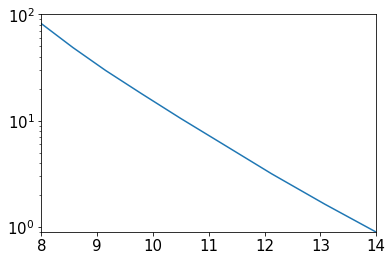

In [16]:
summean=[]
mean,_=surveys['JADES Deep']
widem=np.sum(mean, axis=1)
widem=np.cumsum(widem)
plt.plot(z_vals, widem)
plt.yscale('log')
plt.ylim(bottom=0.9, top=1e2)
plt.xlim(8,14)

In [17]:
def mass_func_fill(sur, k, mean, sig, ax=None, legend=True, c='r',start=1, norm=150, save=False, i=0, scale='log', top=None, bottom=1e-7):
    mass=masses[start:]
    h=cosmo.H0.value/100
    dz=[z_vals[k+1]-z_vals[k],z_vals[k]-z_vals[k-1]]
    norm=(cosmo.comoving_volume(k+dz[0]/2)-cosmo.comoving_volume(k-dz[1]/2))*area_dict[sur]
    norm=norm*h**3
    errcv=sig*mean
    errtot=np.sqrt(mean+(errcv)**2)
    poiserr=np.sqrt(mean)
    errcv, errtot, poiserr, mean=errcv/norm, errtot/norm, poiserr/norm, mean/norm
    if ax==None:
        fig, ax=plt.subplots(figsize=(12,9))
    else:
        s=0
        
    if i==0:
        ax.plot(mass, mean[k][start:], c, label=f'Mass function for {sur}')
        ax.fill_between(mass, mean[k][start:]+poiserr[k][start:],mean[k][start:]-poiserr[k][start:], color = c, alpha=0.4,
                    label='Poisson uncertainty')
        ax.fill_between(mass, mean[k][start:]+errcv[k][start:],mean[k][start:]-errcv[k][start:], color = c, alpha=0.2,
                    label='Cosmic Variance')
        ax.fill_between(mass, mean[k][start:]+ errtot[k][start:], mean[k][start:]- errtot[k][start:], color =c, alpha=0.1,
                    label='Total statistical uncertainty')
    else:
        ax.plot(mass, mean[k][start:], c, label=f'Mass function for {sur}')
        ax.fill_between(mass, mean[k][start:]+poiserr[k][start:],mean[k][start:]-poiserr[k][start:], color = c, alpha=0.4)
        ax.fill_between(mass, mean[k][start:]+errcv[k][start:],mean[k][start:]-errcv[k][start:], color = c, alpha=0.2)
        ax.fill_between(mass, mean[k][start:]+ errtot[k][start:], mean[k][start:]- errtot[k][start:], color =c, alpha=0.1)
    if legend:
        ax.yaxis.grid(color='gray', linestyle='dashed')
        # ax.hlines(1,8,11, 'k', linestyle='dashed')
        ax.set(xlabel=r'Mass [$log(\frac{M_*}{M_\odot})$]', ylabel=r'n [$\frac{h^3}{Mpc^3}}$]',\
               title=f'Mass function at z={np.round(z_vals[k],1)} for different survey designs', yscale=scale)
        ax.set_ylim(bottom, top)
        ax.legend(fontsize=10, loc='upper left')
    if save:
        plt.savefig(f'figs/masslumfunc/z_{np.round(z_vals[k],1)}_total.png')

In [18]:
colours=['b', 'g', 'r', 'm', 'y', 'darkorange', 'turquoise']
surveynames=['JADES Deep', 'JADES Medium', 'JADES Deep Extended', 'JADES Medium Extended', '1 pointing', '20 pointings', '100 pointings', '1000 pointings']
surveynames=['JADES Deep', 'JADES Medium','1 pointing', '20 pointings', '100 pointings', '1000 pointings']

C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max

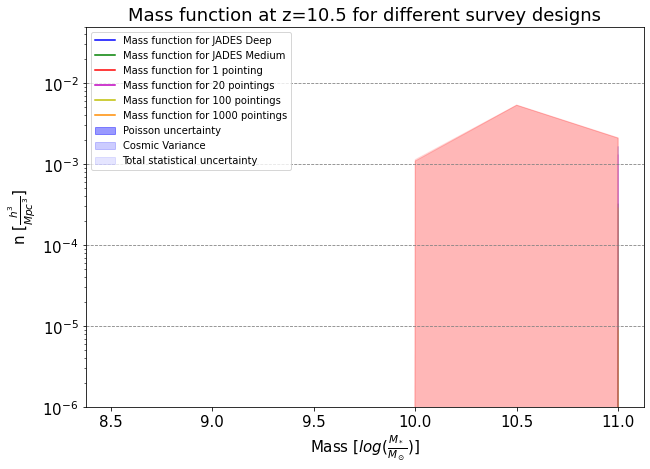

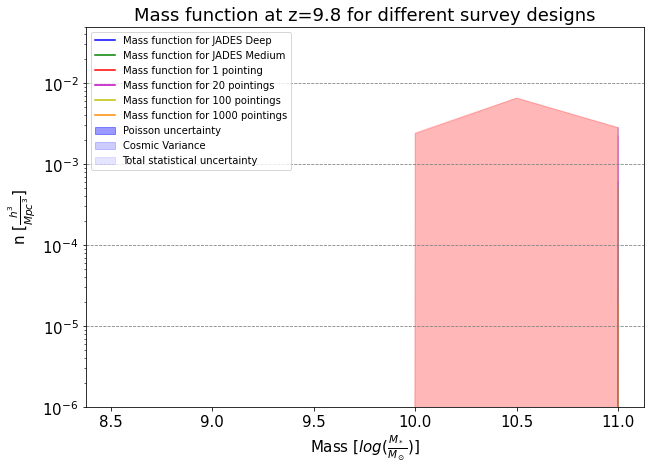

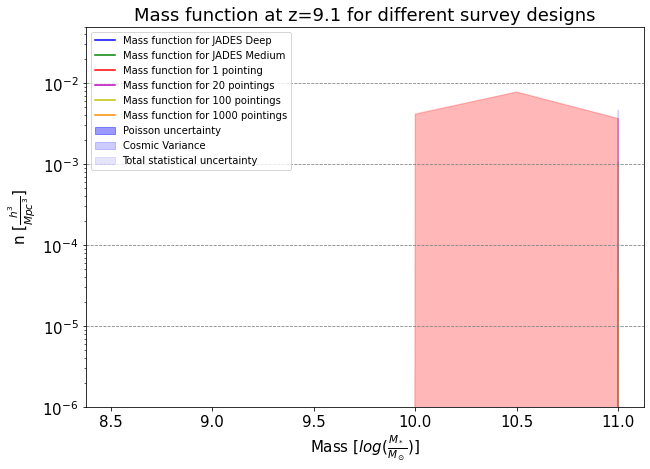

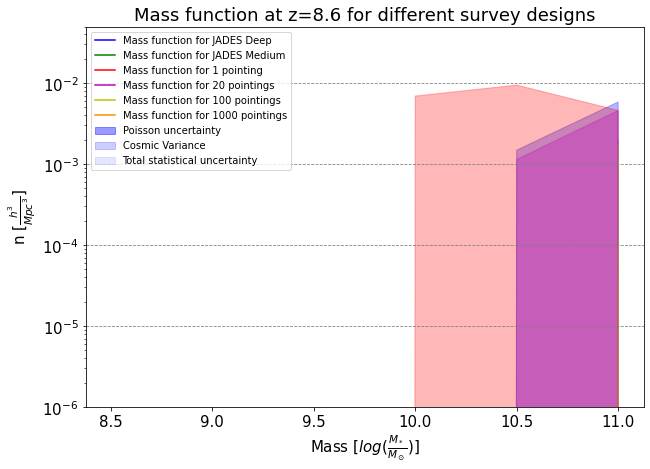

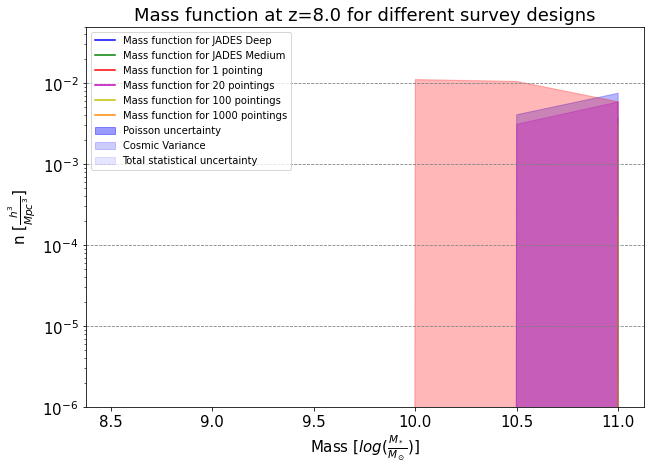

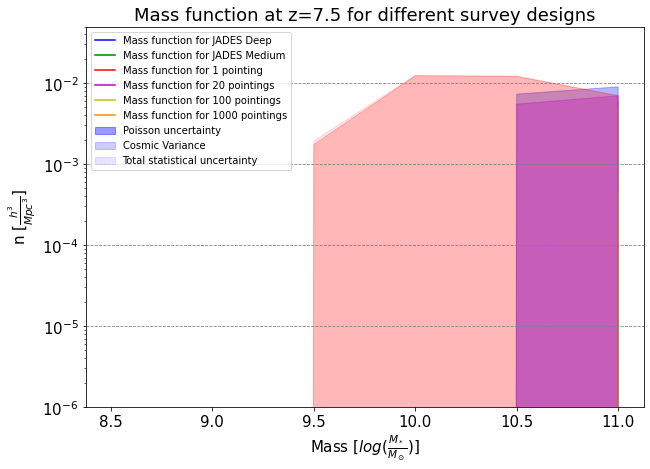

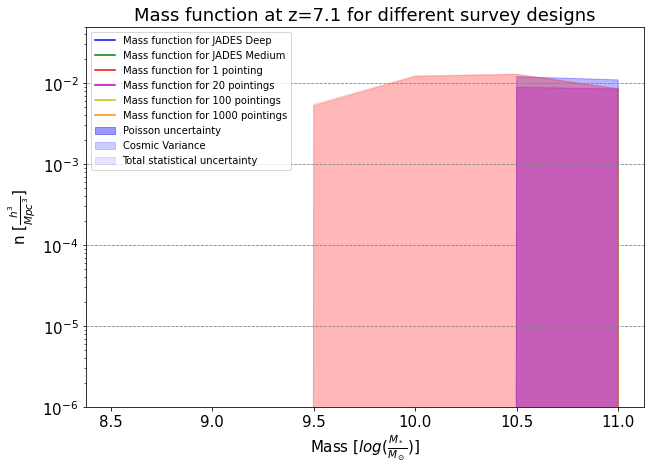

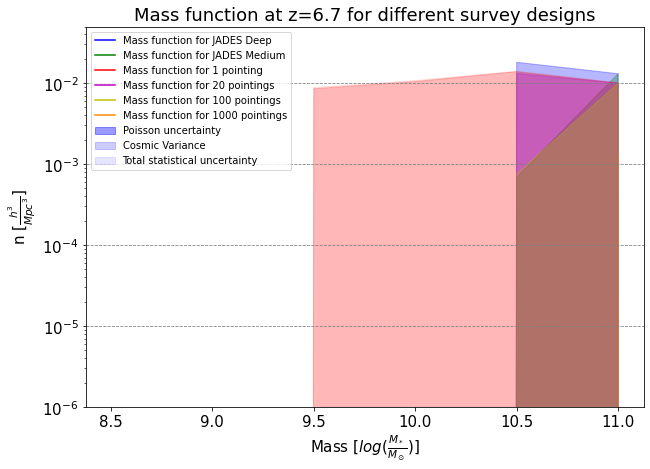

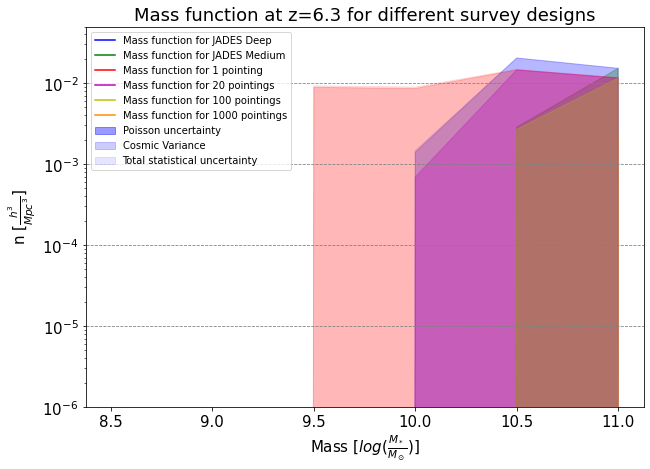

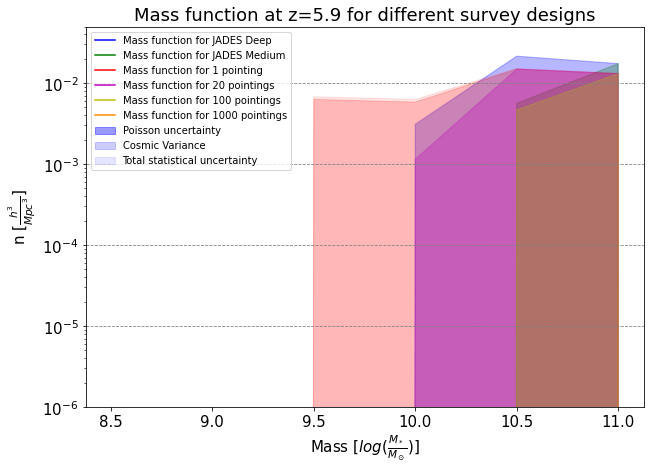

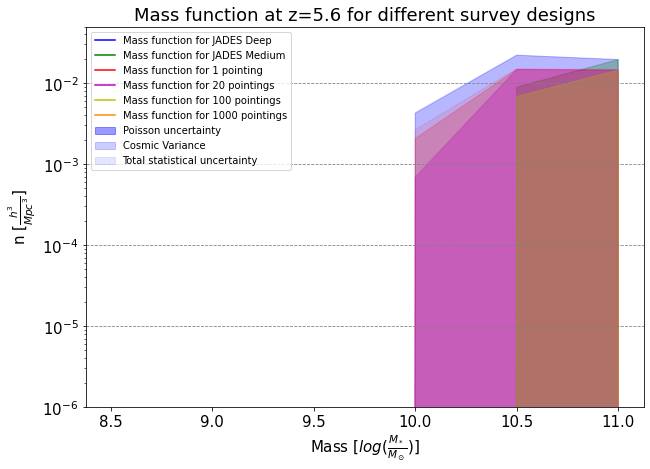

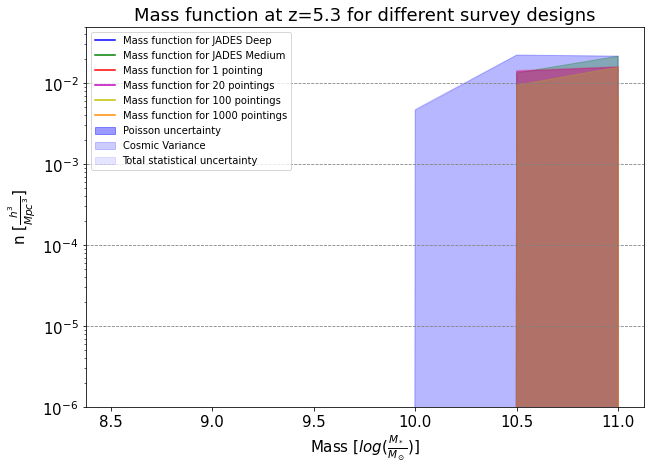

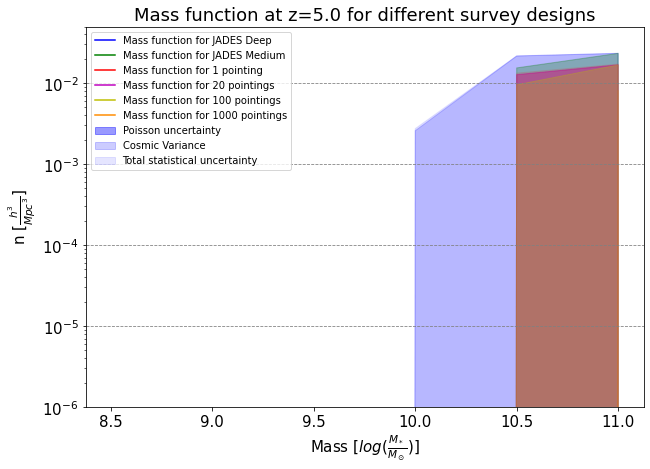

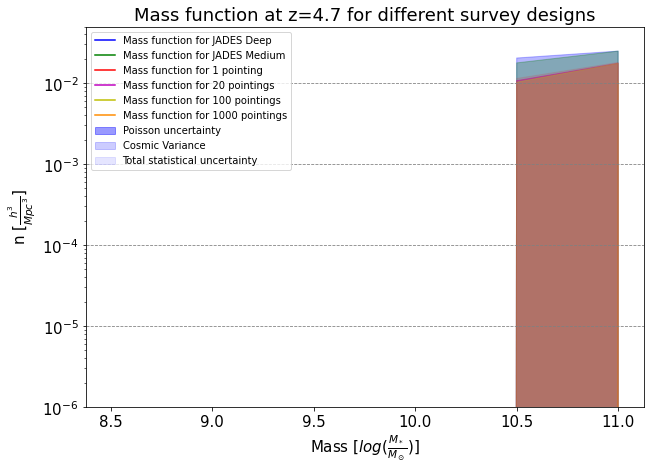

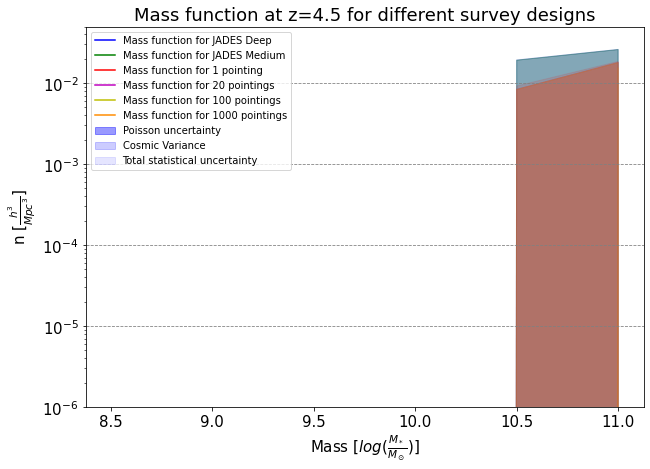

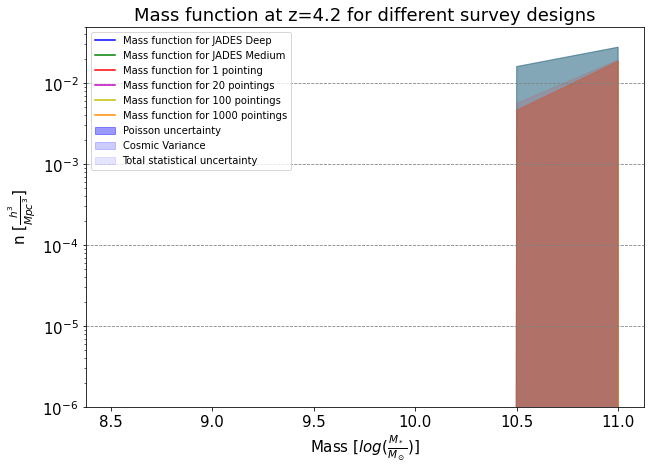

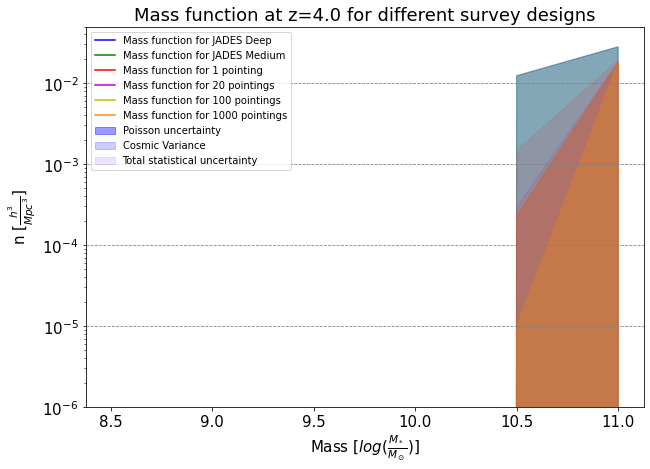

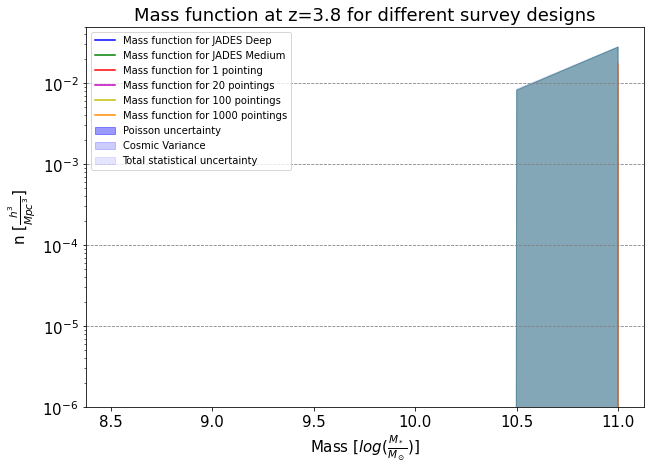

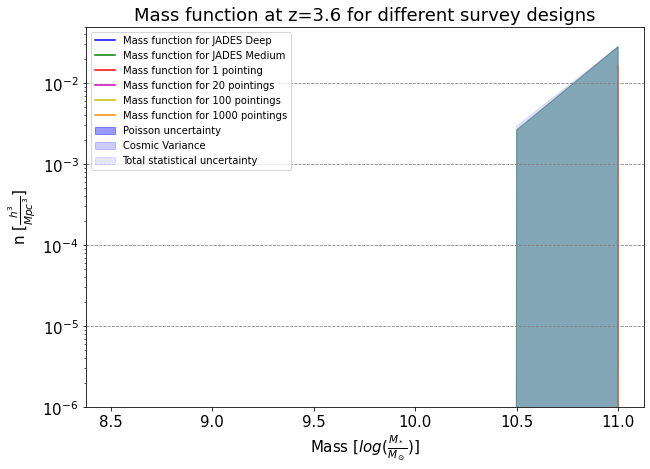

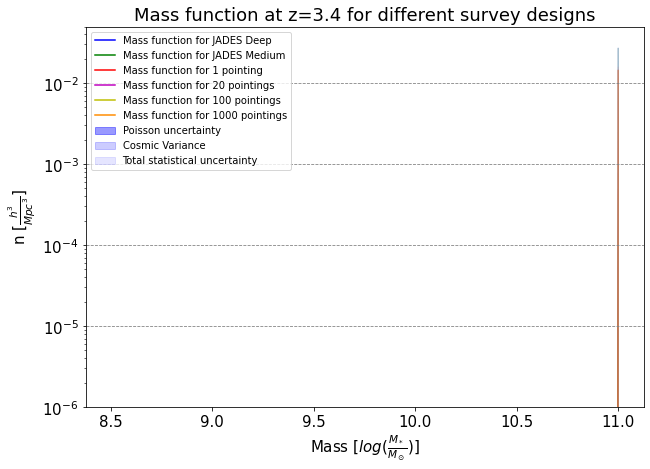

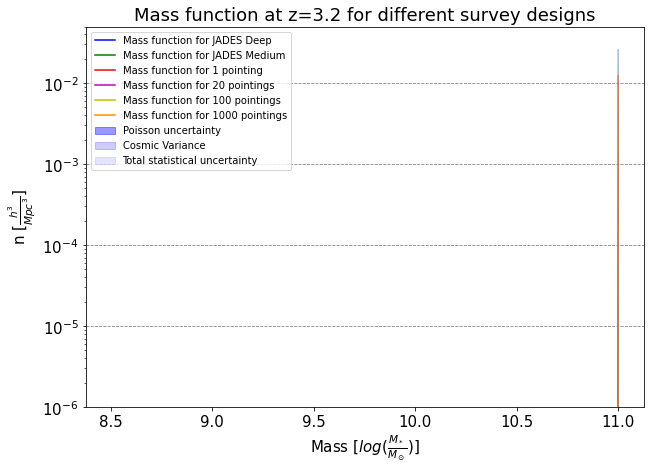

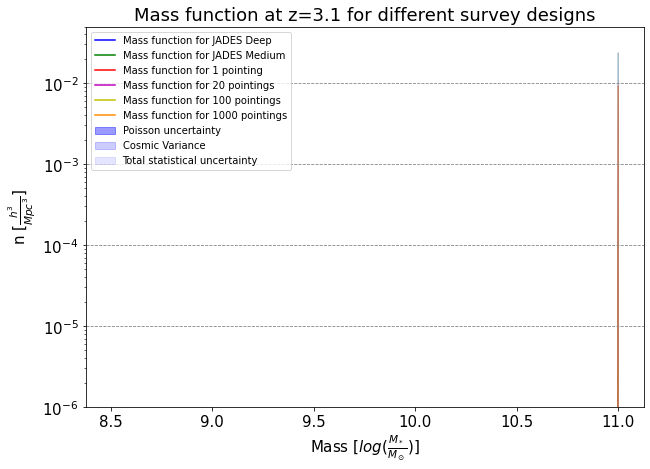

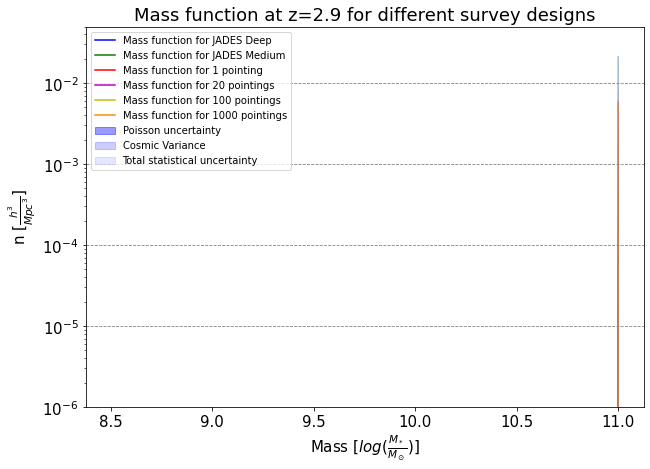

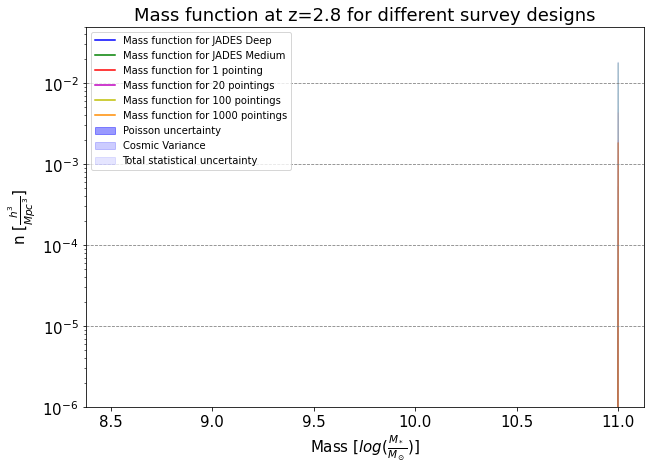

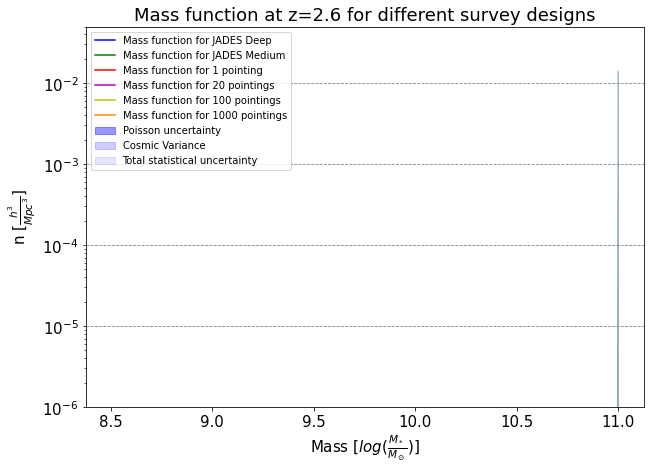

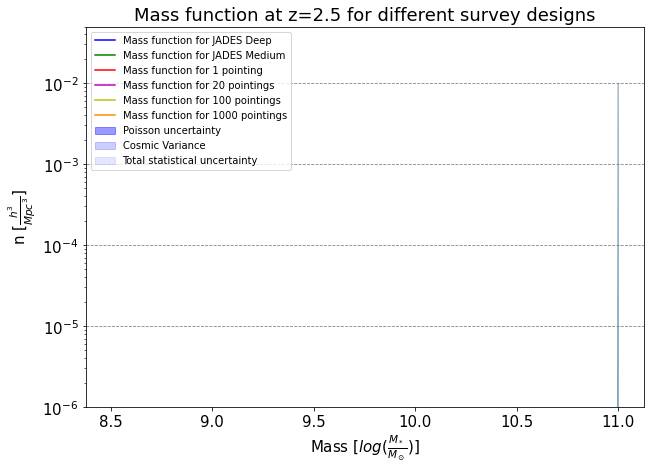

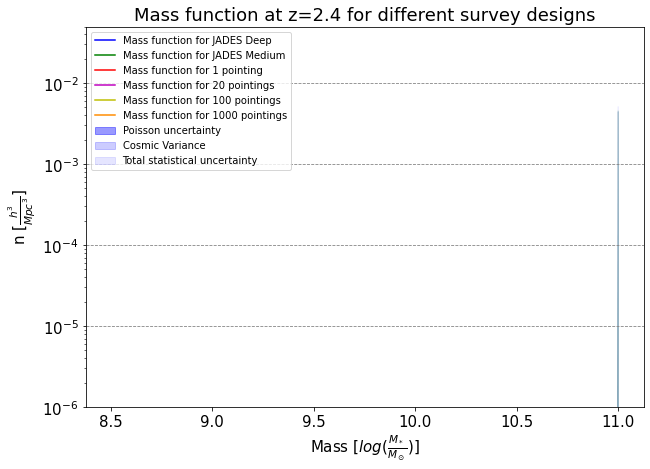

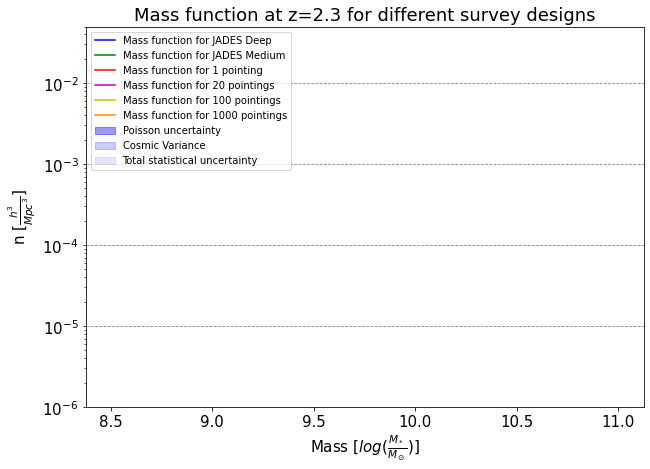

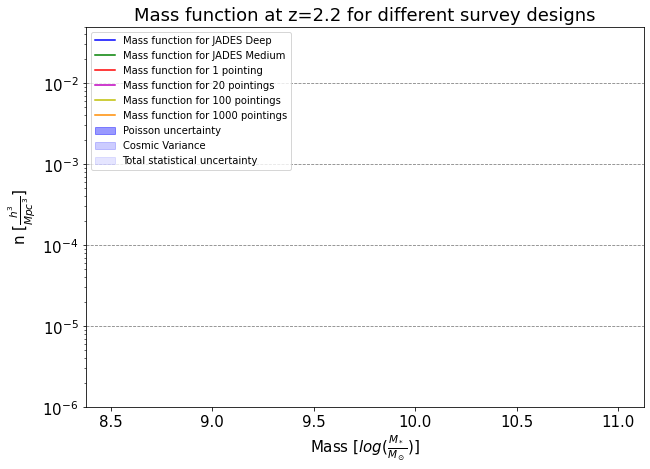

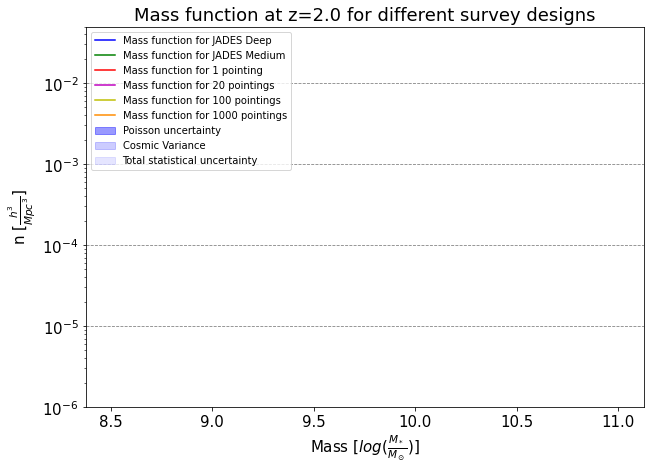

In [19]:
for k in range(10,40):
    fig, ax=plt.subplots(figsize=(10,7))
    i=0
    k=k
    for sname in surveynames:
        s=sname
        means, sigs=surveys[s]
        mass_func_fill(s, k, means, sigs, c=colours[i], save=1, ax=ax, scale='log', i=i, top=0.05, bottom=1e-6)
        i+=1

TypeError: can't multiply sequence by non-int of type 'str'

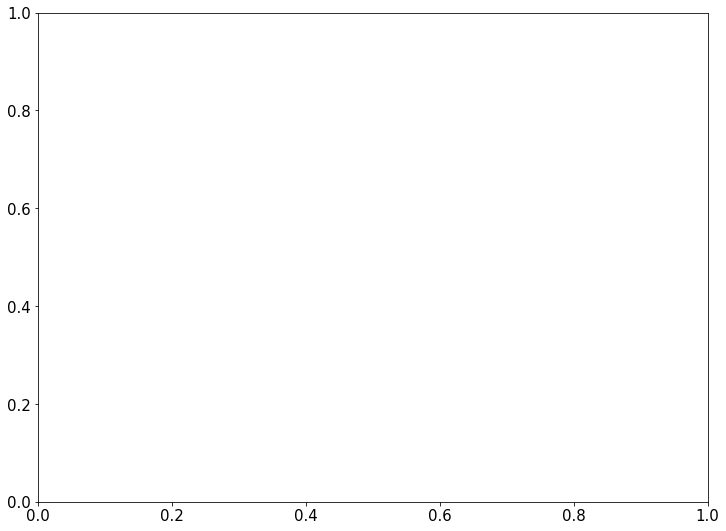

In [20]:
fig, ax=plt.subplots(figsize=(12,9))
i=0
k=20
for vals in surveys:
    if i==1: 
        mass_func_fill(s, k, vals[0], vals[1], ax=ax, c=colours[i])
        ax.legend()
    i+=1
    
ax.yaxis.grid(color='gray', linestyle='dashed')
ax.hlines(1,8,11, 'k', linestyle='dashed')
ax.set(xlabel=r'Mass [$log(\frac{M_*}{M_\odot})$]', ylabel=r'n [$\frac{h^3}{Mpc^3}}$]',\
       title=f'Mass function at z={np.round(z_vals[k],1)} for different survey designs', yscale='linear')
# ax.set_ylim(1e-20)
fig.tight_layout(rect=(0,0,1,0.95))

In [ ]:
# Survey design matching the JADES Deep survey from Williams et al. 2018 (pg. 36)
deep = survey(30.7, 46./3600, "cv_jades_deep.csv", nearest_wavelength(x,14873.4))
massmean, sigdeep = mean_median(deep)
N=20
high=6
fig, ax=plt.subplots(5,4,figsize=(25,20))
ax=ax.flatten()
for k in range(high,high+N):
    errsdeep=np.sqrt(massmean+(sigdeep*massmean)**2)
    errscvdeep=sigdeep*massmean
    ax[k-high].plot(masses, massmean[k], 'r.', label='Mass function')
    ax[k-high].errorbar(masses, massmean[k], errsdeep[k], color = 'k', elinewidth = 1, capsize = 2, ls = 'none',\
                label='Total statistical uncertainty')
    ax[k-high].errorbar(masses, massmean[k], errscvdeep[k], color = 'y',alpha=0.5, elinewidth = 1, capsize = 2, ls = 'none',\
                label='Cosmic Variance')
    poiserrdeep=np.sqrt(massmean)
    ax[k-high].errorbar(masses, massmean[k], poiserrdeep[k], color = 'r',alpha=0.3, elinewidth = 1, capsize = 2, ls = 'none',\
                label='Poisson uncertainty')
    ax[k-high].set(xlabel='Mass', ylabel='N', title=f'Mass function at z={np.round(z_vals[k],1)}', yscale='log')
    ax[k-high].set_ylim(bottom=1e-6)
    ax[k-high].legend();
fig.tight_layout(rect=(0,0,1,0.95))
fig.suptitle(f'Observed mass function for JADES deep ')

In [ ]:
k=14
print(z_vals[k])
fig, ax=plt.subplots(figsize=(12,9))
errscvdeep=sigwide*meanswide
errswide=np.sqrt(meanswide+(sigwide*meanswide)**2)
ax.plot(masses, meanswide[k], 'r.', label='Mass function')
ax.errorbar(masses, meanswide[k], errswide[k], color = 'k', elinewidth = 1, capsize = 2, ls = 'none',\
            label='Total statistical uncertainty')
ax.errorbar(masses, meanswide[k], errscvdeep[k], color = 'y',alpha=0.8, elinewidth = 1, capsize = 2, ls = 'none',\
                label='Cosmic Variance')
poiserrwide=np.sqrt(meanswide)
ax.errorbar(masses, meanswide[k], poiserrwide[k], color = 'r', alpha=0.5, elinewidth = 1, capsize = 2, ls = 'none',\
            label='Poisson uncertainty')
ax.yaxis.grid(color='gray', linestyle='dashed')
# ax.hlines(1,8,11, 'k', linestyle='dashed')
ax.set(xlabel='Mass', ylabel='N', title=f'Mass function at z={np.round(z_vals[k],1)} for JADES Medium', yscale='log')
ax.set_ylim(bottom=1e-6)
ax.legend()

plt.savefig('figs/masslumfunc/10.5medium.png')

In [ ]:
# Survey design matching the JADES Medium survey from Williams et al. 2018 (pg. 36)
wide = survey(29.85, 190./3600, "cv_jades_wide.csv", nearest_wavelength(x,14873.4))
meanswide, sigwide = mean_median(wide)

In [ ]:
def mass_func(survey, k, mean, sig, norm=200**3, save=False, bottom=1e-10):
    h=cosmo.H0.value/100
    norm=norm*h**3
    fig, ax=plt.subplots(figsize=(12,9))
    errcv=sig*mean
    errtot=np.sqrt(mean+(errcv)**2)
    poiserr=np.sqrt(mean)
    errcv, errtot, poiserr, mean=errcv/norm, errtot/norm, poiserr/norm, mean/norm
    ax.plot(masses, mean[k], 'r.', label='Mass function')
    ax.errorbar(masses, mean[k], errtot[k], color = 'k', elinewidth = 1, capsize = 2, ls = 'none',\
                label='Total statistical uncertainty')
    ax.errorbar(masses, mean[k], errcv[k], color = 'y',alpha=0.8, elinewidth = 1, capsize = 2, ls = 'none',\
                    label='Cosmic Variance')
    ax.errorbar(masses, mean[k], poiserr[k], color = 'r', alpha=0.5, elinewidth = 1, capsize = 2, ls = 'none',\
                label='Poisson uncertainty')
    ax.yaxis.grid(color='gray', linestyle='dashed')
    # ax.hlines(1,8,11, 'k', linestyle='dashed')
    ax.set(xlabel=r'Mass [$log(\frac{M_*}{M_\odot})$]', ylabel=r'n [$\frac{h^3}{Mpc^3}}$]', title=f'Mass function at z={np.round(z_vals[k],1)} for {survey}', yscale='log')
    ax.set_ylim(bottom=bottom)
    ax.legend()
    fig.tight_layout(rect=(0,0,1,0.95))
    if save:
        plt.savefig(f'figs/masslumfunc/z_{np.round(z_vals[k],1)}_{survey}.png')

In [ ]:
mass_func('JADES medium', 10, meanswide, sigwide, bottom=1e-15)

In [ ]:
mass_func_fill('JADES medium', 12, meanswide, sigwide, bottom=1e-7, top=1e-5)

In [ ]:
mass_func_fill('JADES medium', 12, meanswide, sigwide, bottom=1e-7, top=1e-5)

In [ ]:
for k in range(20):
# k=15
    points = [(1,32.2),(20,30.7),(100,29.85),(1000,28.5)]
    point = survey(mag, 2*4.84/3600, "cv_one_pointing.csv", nearest_wavelength(x,14873.4), p)
    means, sig = mean_median(point)
    if max(means[k])>0.5:
        fig, ax=plt.subplots(2,2,figsize=(12,12))
        ax=ax.flatten()
        j=0
        print(z_vals[k], 'accepted')
        for p, mag in points:
            point = survey(mag, 2*4.84/3600, "cv_one_pointing.csv", nearest_wavelength(x,14873.4), p)
            means, sig = mean_median(point)
            poiserr=np.sqrt(means)
            errs=np.sqrt(means+(sig*means)**2)
            errscvpoint=sig*means
            ax[j].plot(masses, means[k], '.', label=f'Mass function')
            ax[j].errorbar(masses, means[k], errs[k], color = 'k', elinewidth = 1, capsize = 2, ls = 'none',\
                        label='Total statistical uncertainty')
            ax[j].errorbar(masses, means[k], poiserr[k], color = 'r', alpha=.4, elinewidth = 1, capsize = 2, ls = 'none',\
                        label='Poisson uncertainty')
            ax[j].errorbar(masses, means[k], errscvpoint[k], color = 'y',alpha=0.7, elinewidth = 1, capsize = 2, ls = 'none',\
                    label='Cosmic Variance')
            if j==0:
                ax[j].set(xlabel='Mass [log(M/M_*)]', ylabel='N',\
                   title=f'{p} independent pointing', yscale='log')
            else:
                ax[j].set(xlabel='Mass [log(M/M_*)]', ylabel='N',\
                       title=f'{p} independent pointings', yscale='log')
            ax[j].set_ylim(bottom=1e-20)
            ax[j].legend()
            j+=1
        fig.suptitle(f'Observed mass function 1 Ms exposure time over n independent pointings at z={np.round(z_vals[k],1)} ')
        if np.round(z_vals[k],1)==10.5:
            plt.savefig('figs/masslumfunc/10.5pointings.png')
    else:
        continue

In [ ]:
wide = survey(29.85, 190./3600, "cv_jades_wide.csv", nearest_wavelength(x,14873.4))
massmean, sigdeep = mean_median(wide)